In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/goodreads-books-reviews-290312/goodreads_test.csv
/kaggle/input/goodreads-books-reviews-290312/goodreads_sample_submission.csv
/kaggle/input/goodreads-books-reviews-290312/goodreads_train.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

from wordcloud import WordCloud
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, ConfusionMatrixDisplay
import pickle

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import string
import nltk
import nltk.corpus
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [3]:
test_data = pd.read_csv("/kaggle/input/goodreads-books-reviews-290312/goodreads_test.csv")
train = pd.read_csv("/kaggle/input/goodreads-books-reviews-290312/goodreads_train.csv")

# **Data Understanding**

In [4]:
train.head()

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,8842281e1d1347389f2ab93d60773d4d,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,This is a special book. It started slow for ab...,Sun Jul 30 07:44:10 -0700 2017,Wed Aug 30 00:00:26 -0700 2017,Sat Aug 26 12:05:52 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,28,1
1,8842281e1d1347389f2ab93d60773d4d,16981,a5d2c3628987712d0e05c4f90798eb67,3,Recommended by Don Katz. Avail for free in Dec...,Mon Dec 05 10:46:44 -0800 2016,Wed Mar 22 11:37:04 -0700 2017,NaN,NaN,1,0
2,8842281e1d1347389f2ab93d60773d4d,28684704,2ede853b14dc4583f96cf5d120af636f,3,"A fun, fast paced science fiction thriller. I ...",Tue Nov 15 11:29:22 -0800 2016,Mon Mar 20 23:40:27 -0700 2017,Sat Mar 18 23:22:42 -0700 2017,Fri Mar 17 23:45:40 -0700 2017,22,0
3,8842281e1d1347389f2ab93d60773d4d,27161156,ced5675e55cd9d38a524743f5c40996e,0,Recommended reading to understand what is goin...,Wed Nov 09 17:37:04 -0800 2016,Wed Nov 09 17:38:20 -0800 2016,NaN,NaN,5,1
4,8842281e1d1347389f2ab93d60773d4d,25884323,332732725863131279a8e345b63ac33e,4,"I really enjoyed this book, and there is a lot...",Mon Apr 25 09:31:23 -0700 2016,Mon Apr 25 09:31:23 -0700 2016,Sun Jun 26 00:00:00 -0700 2016,Sat May 28 00:00:00 -0700 2016,9,1


In [5]:
test_data.head()

,user_id,book_id,review_id,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,b9450d1c1f97f891c392b1105959b56e,7092507,5c4df7e70e9b438c761f07a4620ccb7c,** spoiler alert ** \n This is definitely one ...,Sat Nov 10 06:06:13 -0800 2012,Sun Nov 11 05:38:36 -0800 2012,Sun Nov 11 05:38:36 -0800 2012,Sat Nov 10 00:00:00 -0800 2012,1,0
1,b9450d1c1f97f891c392b1105959b56e,5576654,8eaeaf13213eeb16ad879a2a2591bbe5,"** spoiler alert ** \n ""You are what you drink...",Fri Nov 09 21:55:16 -0800 2012,Sat Nov 10 05:41:49 -0800 2012,Sat Nov 10 05:41:49 -0800 2012,Fri Nov 09 00:00:00 -0800 2012,1,0
2,b9450d1c1f97f891c392b1105959b56e,15754052,dce649b733c153ba5363a0413cac988f,Roar is one of my favorite characters in Under...,Fri Nov 09 00:25:50 -0800 2012,Sat Nov 10 06:14:10 -0800 2012,Sat Nov 10 06:14:10 -0800 2012,Fri Nov 09 00:00:00 -0800 2012,0,0
3,b9450d1c1f97f891c392b1105959b56e,17020,8a46df0bb997269d6834f9437a4b0a77,** spoiler alert ** \n If you feel like travel...,Thu Nov 01 00:28:39 -0700 2012,Sat Nov 03 11:35:22 -0700 2012,Sat Nov 03 11:35:22 -0700 2012,Thu Nov 01 00:00:00 -0700 2012,0,0
4,b9450d1c1f97f891c392b1105959b56e,12551082,d11d3091e22f1cf3cb865598de197599,3.5 stars \n I read and enjoyed the first two ...,Thu Oct 18 00:57:00 -0700 2012,Mon Apr 01 23:00:51 -0700 2013,Sat Mar 30 00:00:00 -0700 2013,Fri Mar 29 00:00:00 -0700 2013,0,0


In [6]:
train.shape

(900000, 11)

In [7]:
test_data.shape

(478033, 10)

In [8]:
train.sample(5)

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
793549,4828ba4c96384ec5a0d8b4818fe22e09,26242642,50d292e0b82b87c4b9e48207be0e707a,4,Three things I loved about this YA novel: (1) ...,Tue Nov 08 09:28:59 -0800 2016,Sat Nov 26 07:17:50 -0800 2016,Fri Nov 25 00:00:00 -0800 2016,Tue Nov 22 00:00:00 -0800 2016,0,0
41349,8e7e5b546a63cb9add8431ee6914cf59,6457229,1b8b7dd7f44dddee77731aa56fd8bf16,4,I burbled on the the Spouse yesterday about ho...,Tue Jul 08 13:06:38 -0700 2014,Sun Aug 27 06:40:47 -0700 2017,Mon Nov 01 00:00:00 -0700 2010,NaN,0,0
318481,913cd593a90ebd5455e7db3a082530e6,6567017,f4bf23fc0e135c6259a12488ac0f256f,5,Read for a second time in my giddy impatience ...,Tue Jan 18 16:38:13 -0800 2011,Mon Jan 05 07:00:35 -0800 2015,Mon Jan 09 00:00:00 -0800 2012,NaN,1,2
713073,39b03348f2fc24c8cfcd05affa61858f,8755776,1eeffb9c665272965b5dfbdf609227bf,4,Loved it as usual!!!,Tue Apr 07 06:38:03 -0700 2015,Sat Dec 19 06:44:44 -0800 2015,Sat Dec 19 06:44:44 -0800 2015,Mon Dec 14 00:00:00 -0800 2015,0,0
573078,d3bb92491935a6efe3c3aa21ad683e7e,9462812,be2c27ac43f505cfa41849609a5a08ea,4,I really like this series.. my only issue was ...,Thu Aug 28 21:25:45 -0700 2014,Mon Mar 09 06:06:03 -0700 2015,Sun Mar 08 00:00:00 -0800 2015,NaN,0,0


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900000 entries, 0 to 899999
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       900000 non-null  object
 1   book_id       900000 non-null  int64 
 2   review_id     900000 non-null  object
 3   rating        900000 non-null  int64 
 4   review_text   900000 non-null  object
 5   date_added    900000 non-null  object
 6   date_updated  900000 non-null  object
 7   read_at       808234 non-null  object
 8   started_at    625703 non-null  object
 9   n_votes       900000 non-null  int64 
 10  n_comments    900000 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 75.5+ MB


In [10]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478033 entries, 0 to 478032
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       478033 non-null  object
 1   book_id       478033 non-null  int64 
 2   review_id     478033 non-null  object
 3   review_text   478033 non-null  object
 4   date_added    478033 non-null  object
 5   date_updated  478033 non-null  object
 6   read_at       435555 non-null  object
 7   started_at    334989 non-null  object
 8   n_votes       478033 non-null  int64 
 9   n_comments    478033 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 36.5+ MB


In [11]:
train.isnull().mean()*100

user_id          0.000000
book_id          0.000000
review_id        0.000000
rating           0.000000
review_text      0.000000
date_added       0.000000
date_updated     0.000000
read_at         10.196222
started_at      30.477444
n_votes          0.000000
n_comments       0.000000
dtype: float64

In [12]:
test_data.isnull().mean()*100

user_id          0.000000
book_id          0.000000
review_id        0.000000
review_text      0.000000
date_added       0.000000
date_updated     0.000000
read_at          8.885997
started_at      29.923457
n_votes          0.000000
n_comments       0.000000
dtype: float64

In [13]:
train.duplicated().sum()

0

In [14]:
test_data.duplicated().sum()

0

# **Data Cleaning / Preprocessing**

In [15]:
train.head()

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,8842281e1d1347389f2ab93d60773d4d,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,This is a special book. It started slow for ab...,Sun Jul 30 07:44:10 -0700 2017,Wed Aug 30 00:00:26 -0700 2017,Sat Aug 26 12:05:52 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,28,1
1,8842281e1d1347389f2ab93d60773d4d,16981,a5d2c3628987712d0e05c4f90798eb67,3,Recommended by Don Katz. Avail for free in Dec...,Mon Dec 05 10:46:44 -0800 2016,Wed Mar 22 11:37:04 -0700 2017,NaN,NaN,1,0
2,8842281e1d1347389f2ab93d60773d4d,28684704,2ede853b14dc4583f96cf5d120af636f,3,"A fun, fast paced science fiction thriller. I ...",Tue Nov 15 11:29:22 -0800 2016,Mon Mar 20 23:40:27 -0700 2017,Sat Mar 18 23:22:42 -0700 2017,Fri Mar 17 23:45:40 -0700 2017,22,0
3,8842281e1d1347389f2ab93d60773d4d,27161156,ced5675e55cd9d38a524743f5c40996e,0,Recommended reading to understand what is goin...,Wed Nov 09 17:37:04 -0800 2016,Wed Nov 09 17:38:20 -0800 2016,NaN,NaN,5,1
4,8842281e1d1347389f2ab93d60773d4d,25884323,332732725863131279a8e345b63ac33e,4,"I really enjoyed this book, and there is a lot...",Mon Apr 25 09:31:23 -0700 2016,Mon Apr 25 09:31:23 -0700 2016,Sun Jun 26 00:00:00 -0700 2016,Sat May 28 00:00:00 -0700 2016,9,1


In [16]:
train = train[["review_text", "rating"]].iloc[:20000,:]
test = train[["review_text"]]

In [17]:
train.shape

(20000, 2)

In [18]:
train.head()

,review_text,rating
0,This is a special book. It started slow for ab...,5
1,Recommended by Don Katz. Avail for free in Dec...,3
2,"A fun, fast paced science fiction thriller. I ...",3
3,Recommended reading to understand what is goin...,0
4,"I really enjoyed this book, and there is a lot...",4


In [19]:
train["review_text"][0]

'This is a special book. It started slow for about the first third, then in the middle third it started to get interesting, then the last third blew my mind. This is what I love about good science fiction - it pushes your thinking about where things can go. \n It is a 2015 Hugo winner, and translated from its original Chinese, which made it interesting in just a different way from most things I\'ve read. For instance the intermixing of Chinese revolutionary history - how they kept accusing people of being "reactionaries", etc. \n It is a book about science, and aliens. The science described in the book is impressive - its a book grounded in physics and pretty accurate as far as I could tell. (view spoiler)[Though when it got to folding protons into 8 dimensions I think he was just making stuff up - interesting to think about though. \n But what would happen if our SETI stations received a message - if we found someone was out there - and the person monitoring and answering the signal o

In [20]:
train["rating"].value_counts()

4    7204
5    6294
3    4204
2    1366
1     509
0     423
Name: rating, dtype: int64

In [21]:
#REMOVING LINKS, PUNCTUATIONS and CREATING TOKENS(TOKENISATION)

def preprocessing1(text):
    te = re.sub(r'http\S+', "", text)
    tokens = word_tokenize(te)
    
    punctuations = string.punctuation
    txt = []
    for i in tokens:
        if i not in punctuations:
            txt.append(i)
    return txt

In [22]:
train["review_text"] = train["review_text"].apply(preprocessing1)

In [23]:
train["review_text"][0]

['This',
 'is',
 'a',
 'special',
 'book',
 'It',
 'started',
 'slow',
 'for',
 'about',
 'the',
 'first',
 'third',
 'then',
 'in',
 'the',
 'middle',
 'third',
 'it',
 'started',
 'to',
 'get',
 'interesting',
 'then',
 'the',
 'last',
 'third',
 'blew',
 'my',
 'mind',
 'This',
 'is',
 'what',
 'I',
 'love',
 'about',
 'good',
 'science',
 'fiction',
 'it',
 'pushes',
 'your',
 'thinking',
 'about',
 'where',
 'things',
 'can',
 'go',
 'It',
 'is',
 'a',
 '2015',
 'Hugo',
 'winner',
 'and',
 'translated',
 'from',
 'its',
 'original',
 'Chinese',
 'which',
 'made',
 'it',
 'interesting',
 'in',
 'just',
 'a',
 'different',
 'way',
 'from',
 'most',
 'things',
 'I',
 "'ve",
 'read',
 'For',
 'instance',
 'the',
 'intermixing',
 'of',
 'Chinese',
 'revolutionary',
 'history',
 'how',
 'they',
 'kept',
 'accusing',
 'people',
 'of',
 'being',
 '``',
 'reactionaries',
 "''",
 'etc',
 'It',
 'is',
 'a',
 'book',
 'about',
 'science',
 'and',
 'aliens',
 'The',
 'science',
 'described',
 

In [24]:
#REMOVING STOPWORDS & CONVERTING TO LOWERCASE

def preprocessing2(text):
    stopword = stopwords.words("english")
    ntxt = []
    for j in text:
        if j not in stopword:
            ntxt.append(j.lower())
    return ntxt

In [25]:
train["review_text"] = train["review_text"].apply(preprocessing2)

In [26]:
train["review_text"][0]

['this',
 'special',
 'book',
 'it',
 'started',
 'slow',
 'first',
 'third',
 'middle',
 'third',
 'started',
 'get',
 'interesting',
 'last',
 'third',
 'blew',
 'mind',
 'this',
 'i',
 'love',
 'good',
 'science',
 'fiction',
 'pushes',
 'thinking',
 'things',
 'go',
 'it',
 '2015',
 'hugo',
 'winner',
 'translated',
 'original',
 'chinese',
 'made',
 'interesting',
 'different',
 'way',
 'things',
 'i',
 "'ve",
 'read',
 'for',
 'instance',
 'intermixing',
 'chinese',
 'revolutionary',
 'history',
 'kept',
 'accusing',
 'people',
 '``',
 'reactionaries',
 "''",
 'etc',
 'it',
 'book',
 'science',
 'aliens',
 'the',
 'science',
 'described',
 'book',
 'impressive',
 'book',
 'grounded',
 'physics',
 'pretty',
 'accurate',
 'far',
 'i',
 'could',
 'tell',
 'view',
 'spoiler',
 'though',
 'got',
 'folding',
 'protons',
 '8',
 'dimensions',
 'i',
 'think',
 'making',
 'stuff',
 'interesting',
 'think',
 'though',
 'but',
 'would',
 'happen',
 'seti',
 'stations',
 'received',
 'message

In [27]:
#STEMMING

def preprocessing3(text):
    stem = []
    Stemmer = PorterStemmer()
    for i in text:
        stem.append(Stemmer.stem(i))
    return " ".join(stem)

In [28]:
train["review_text"] = train["review_text"].apply(preprocessing3)

In [29]:
train["review_text"][0]

"thi special book it start slow first third middl third start get interest last third blew mind thi i love good scienc fiction push think thing go it 2015 hugo winner translat origin chines made interest differ way thing i 've read for instanc intermix chines revolutionari histori kept accus peopl `` reactionari '' etc it book scienc alien the scienc describ book impress book ground physic pretti accur far i could tell view spoiler though got fold proton 8 dimens i think make stuff interest think though but would happen seti station receiv messag found someon person monitor answer signal side disillus that part book bit dark i would like think human reaction discov alien civil hostil would like ender game would band togeth i like book unveil trisolaran cultur game it smart way build empathi also understand 've gone across mani centuri and know 3 bodi problem unsolv math problem but i still n't get made game mayb come next book i love quot `` in long histori scientif progress mani proto

In [30]:
test["review_text"] = test["review_text"].apply(preprocessing1)
test["review_text"] = test["review_text"].apply(preprocessing2)
test["review_text"] = test["review_text"].apply(preprocessing3)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [31]:
test["review_text"][0]

"thi special book it start slow first third middl third start get interest last third blew mind thi i love good scienc fiction push think thing go it 2015 hugo winner translat origin chines made interest differ way thing i 've read for instanc intermix chines revolutionari histori kept accus peopl `` reactionari '' etc it book scienc alien the scienc describ book impress book ground physic pretti accur far i could tell view spoiler though got fold proton 8 dimens i think make stuff interest think though but would happen seti station receiv messag found someon person monitor answer signal side disillus that part book bit dark i would like think human reaction discov alien civil hostil would like ender game would band togeth i like book unveil trisolaran cultur game it smart way build empathi also understand 've gone across mani centuri and know 3 bodi problem unsolv math problem but i still n't get made game mayb come next book i love quot `` in long histori scientif progress mani proto

In [32]:
train.head(10)

,review_text,rating
0,thi special book it start slow first third mid...,5
1,recommend don katz avail free decemb,3
2,a fun fast pace scienc fiction thriller i read...,3
3,recommend read understand go middl america pos...,0
4,i realli enjoy book lot recommend it drag litt...,4
5,a beauti stori it rare encount book good job p...,4
6,5 star give better framework organ stuff stuff...,5
7,numer peopl publish told book year,0
8,anoth hard put nonfict book erik larson i real...,4
9,i love stephenson anoth hit absolut love the g...,5


In [33]:
train.isna().sum()

review_text    0
rating         0
dtype: int64

In [34]:
test.isna().sum()

review_text    0
dtype: int64

In [35]:
train.shape

(20000, 2)

In [36]:
test.shape

(20000, 1)

In [37]:
train.to_csv("Cleaned_train_Details.csv")

In [38]:
test.to_csv("Cleaned_test_Details.csv")

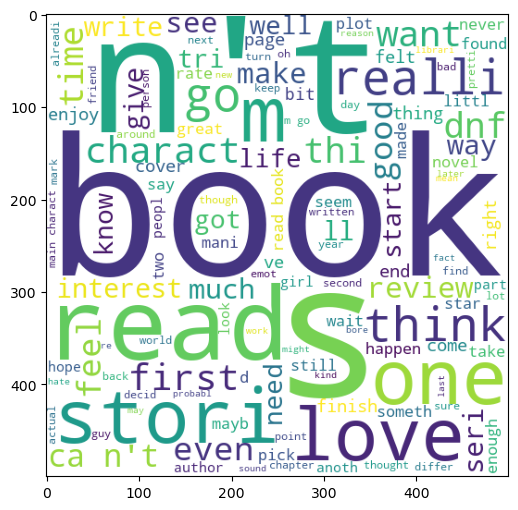

In [39]:
# WordCloud for ham Messages

wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
ham_wc = wc.generate(train[train['rating'] == 0]['review_text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(ham_wc)

# **Model Building¶**

In [40]:
cv = CountVectorizer()
tfd = TfidfVectorizer(max_features=3000)

In [41]:
x = tfd.fit_transform(train["review_text"]).toarray()
y = train["rating"].values

In [42]:
x

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.41101879, ..., 0.        , 0.        ,
        0.        ]])

In [43]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

In [44]:
gnb = GaussianNB()
gnb.fit(x_train, y_train)
pred = gnb.predict(x_test)
print(accuracy_score(y_test,pred)*100)
print(confusion_matrix(y_test,pred))

22.900000000000002
[[ 33  30   9   6   6   5]
 [ 17  26  23  15  12   5]
 [ 45  66  75  52  32  12]
 [133 217 183 147 100  63]
 [180 238 280 216 296 205]
 [225 198 167 131 213 339]]


In [45]:
mnb = MultinomialNB()
mnb.fit(x_train, y_train)
pred = mnb.predict(x_test)
print(accuracy_score(y_test,pred)*100)
print(confusion_matrix(y_test,pred))

48.875
[[   2    0    0   14   44   29]
 [   0    0    4   31   41   22]
 [   0    0    0   94  161   27]
 [   0    0    0  184  572   87]
 [   0    0    0   62 1063  290]
 [   0    0    0    7  560  706]]


In [46]:
bnb = BernoulliNB()
bnb.fit(x_train, y_train)
pred = bnb.predict(x_test)
print(accuracy_score(y_test,pred)*100)
print(confusion_matrix(y_test,pred))

28.475
[[ 68   2   7   7   1   4]
 [ 42  25  13  16   1   1]
 [ 98  33  63  72  14   2]
 [305  37  89 251 102  59]
 [486  36  82 241 278 292]
 [558  20  29  92 120 454]]


knc = SVC(kernel='sigmoid', gamma=1.0)
knc.fit(x_train, y_train)
pred = knc.predict(x_test)
print(accuracy_score(y_test,pred)*100)
print(confusion_matrix(y_test,pred))

In [47]:
# svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
# xgb = XGBClassifier(n_estimators=50,random_state=2)

In [48]:
def model_training(model):
    model.fit(x_train, y_train) 
    pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, pred)
#     precision = precision_score(y_test, pred)
    
    return accuracy

In [49]:
models = {
#     'SVC' : svc,
    'KN' : knc, 
    'NB': mnb, 
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc,
    'AdaBoost': abc, 
    'BgC': bc,
    'ETC': etc,
    'GBDT':gbdt
#     'xgb':xgb
}

In [50]:
accuracy_scores = []
# precision_scores = []

for name, model in models.items():
    
    current_accuracy = model_training(model)
    
    print("For ",name)
    print("Accuracy - ",current_accuracy*100)
#     print("Precision - ",current_precision*100)
    print("====================================")
    
    accuracy_scores.append(current_accuracy)
#     precision_scores.append(current_precision)

For  KN
Accuracy -  22.900000000000002
For  NB
Accuracy -  48.875
For  DT
Accuracy -  40.425
For  LR
Accuracy -  52.225
For  RF
Accuracy -  48.375
For  AdaBoost
Accuracy -  42.125
For  BgC
Accuracy -  48.0
For  ETC
Accuracy -  48.35
For  GBDT
Accuracy -  46.475


In [51]:
model_performance = pd.DataFrame({'Models/Algorithms':models.keys(), 'Accuracy':accuracy_scores}).sort_values('Accuracy', ascending=False)
model_performance

,Models/Algorithms,Accuracy
3,LR,0.52225
1,NB,0.48875
4,RF,0.48375
7,ETC,0.48350
6,BgC,0.48000
8,GBDT,0.46475
5,AdaBoost,0.42125
2,DT,0.40425
0,KN,0.22900


In [52]:
# Voting Classifier 
# Selecting the three Classifiers which are better in case of Accuracy and Precision
# svc = SVC(kernel='sigmoid', gamma=1.0,probability=True)
# mnb = MultinomialNB()
# etc = ExtraTreesClassifier(n_estimators=50, random_state=2)

voting = VotingClassifier(estimators=[('NB', mnb,), ('LR', lrc), ('ETC', etc)], voting='soft')
voting.fit(x_train, y_train)
pred = voting.predict(x_test)

print("Accuracy",accuracy_score(y_test, pred)*100)
# print("Precision",precision_score(y_test, pred)*100)

Accuracy 51.525


In [53]:
# Applying stacking
# Selecting the three Classifiers which are better in case of Accuracy and Precision and Considering Final Estimator as RandomForestClassifier 

estimators=[('NB', mnb,), ('LR', lrc), ('ETC', etc)]
final_estimator=RandomForestClassifier()
stc = StackingClassifier(estimators=estimators, final_estimator=final_estimator)
stc.fit(x_train, y_train)
pred = stc.predict(x_test)

print("Accuracy",accuracy_score(y_test, pred)*100)
# print("Precision",precision_score(y_test, pred)*100)

Accuracy 53.425
